# Plot ApRES melt rates accross the channel profile at KIS2

I used /Users/home/whitefar/DATA/code/APRES/debug_melts.m to look at each melt rate profile and make sure they looked okay.
then /Users/home/whitefar/CODE/apres/apresBatchProcess.m to output KIS2_ApresResults.csv
using Matlab2019 running on co522pc01

## Large error in CP08
Definitely right file, cfg.polyorder=2 dont help. Moving the bed pick dont help.

In [1]:
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate

from shapely.geometry import LineString


import rasterio as rio
import rasterio.mask
import matplotlib as mpl
import pickle


In [2]:
# df = pd.read_csv('/Users/home/whitefar/CODE/apres/KIS2_ApresResults.csv')
df = pd.read_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv')
df['meltRate'] = df.meltRate_v_Epoch1
# df = df.sort_values('x')
# points = [Point(xy) for xy in zip(df.x,df.y) ]
# gdf = gpd.GeoDataFrame(df,geometry=points,crs=3031)

In [3]:
gdfcc = df.query('(Epoch == 3) & cross_channel')
gdfdc = df.query('(Epoch == 3) & down_channel')
gdfcc2 = df.query('(Epoch == 2) & cross_channel')

In [4]:
gdfcc.reset_index(drop=True,inplace=True)
gdfdc.reset_index(drop=True,inplace=True)
gdfcc2.reset_index(drop=True,inplace=True)

In [5]:
df.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain',
       'cross_channel', 'down_channel', 'x', 'y', 'meltRate_v_Epoch1',
       'migrated_res_thickness_at_apres_sites'],
      dtype='object')

# plot where it is on map

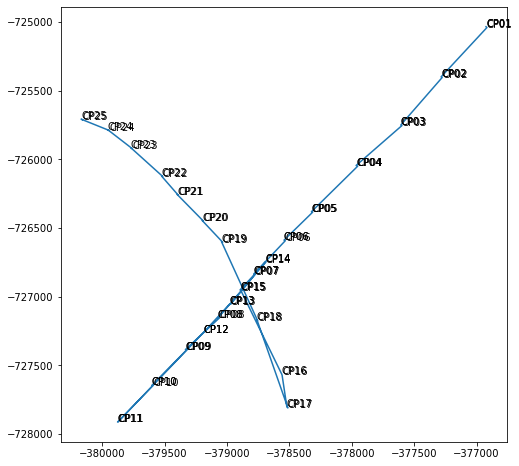

In [6]:
plt.figure(figsize=(8,8))
plt.plot(df.x,df.y)
for i in range(df.shape[0]):
    plt.annotate(df.Site_ID.tolist()[i],list(zip(df.x,df.y))[i])
plt.show()

In [7]:
res_bed_cross = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPREScross"')
res_bed_down = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPRESdown"')                                                                                                              
                                                                                                              

In [8]:
fresbedcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.bed)
gdfcc_res_x = np.linspace(gdfcc.x.min(),gdfcc.x.max(),1000)
gdfcc_res_bed = fresbedcross(gdfcc_res_x)

In [9]:
fresbedcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.ice_thickn)
gdfcc['res_thickn'] = fresbedcross(gdfcc.x-15)
gdfcc.loc[:,['Site_ID','res_thickn']].to_csv('/Users/home/whitefar/DATA/ApRES/migrated_res_thickness_at_apres_sites.csv')

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# fresbeddown = interpolate.interp1d(res_bed_down.x.iloc[startat_res:],res_bed_down.bed.iloc[startat_res:])
# gdfdc['res_bed'] = fresbedcross(gdfdc.x).tolist()

In [11]:
# plt.plot(res_bed_down.x.iloc[startat_res:],res_bed_down.bed.iloc[startat_res:])
# plt.plot(gdfdc.x,-400*np.ones(gdfdc.shape[0]))

In [12]:
gdfcc.shape

(15, 25)

# Plot with the surface as well

In [13]:
df.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain',
       'cross_channel', 'down_channel', 'x', 'y', 'meltRate_v_Epoch1',
       'migrated_res_thickness_at_apres_sites'],
      dtype='object')

In [14]:
df.query('Site_ID == "CP13"')

,Date,utc_time,lat,lon,Approx_Depth,File_Name,AF_Gain,Stacks,RF_Atten,Site_ID,...,meltRateError,bed,dhStrain,dheStrain,cross_channel,down_channel,x,y,meltRate_v_Epoch1,migrated_res_thickness_at_apres_sites
36,2019-12-08,2019-12-08T03:00:00,-82.464378,-152.469052,548.0,2019-12-08_024034.dat,-4.0,64.0,20.0,CP13,...,NaN,NaN,NaN,NaN,True,False,-378979.671586,-727054.074655,NaN,532.971086
37,2019-12-21,2019-12-21T23:59:00,-82.464378,-152.469052,548.0,2019-12-21_235003.dat,-4.0,64.0,20.0,CP13,...,0.027436,548.435139,0.014880,0.001043,True,False,-378979.671586,-727054.074655,-0.436831,532.971086
38,2020-12-23,NaN,-82.464397,-152.469611,548.0,Survey_2020-12-23_030547.dat,-4.0,64.0,20.0,CP13,...,0.090804,548.350047,-3.093236,0.094723,True,False,-378971.619970,-727055.933839,-4.176170,532.971086


In [15]:
df.Site_ID.unique()

array(['CP01', 'CP02', 'CP03', 'CP04', 'CP05', 'CP06', 'CP07', 'CP08',
       'CP09', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15', 'CP16',
       'CP17', 'CP18', 'CP19', 'CP20', 'CP21', 'CP22', 'CP23', 'CP24',
       'CP25'], dtype=object)

In [16]:
radar_APREScross = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineAPREScross.shp')
radar_APREScross.keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073',
       'nid_159199', 'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

In [17]:
radar_APRESdown = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineAPRESdown.shp')
radar_APRESdown.keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_145073',
       'nid_145074', 'nid_159199', 'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

In [18]:
f = interpolate.interp1d(radar_APREScross.geometry.x,radar_APREScross.height)
surf_fordepth = f(gdfcc.x)

In [19]:
startat=130
f2 = interpolate.interp1d(radar_APRESdown.geometry.x.iloc[startat:],radar_APRESdown.height.iloc[startat:])
surf_fordepth2 = f2(gdfdc.x)

In [20]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [21]:
xgrid = np.arange(-382000,-374000,1000)

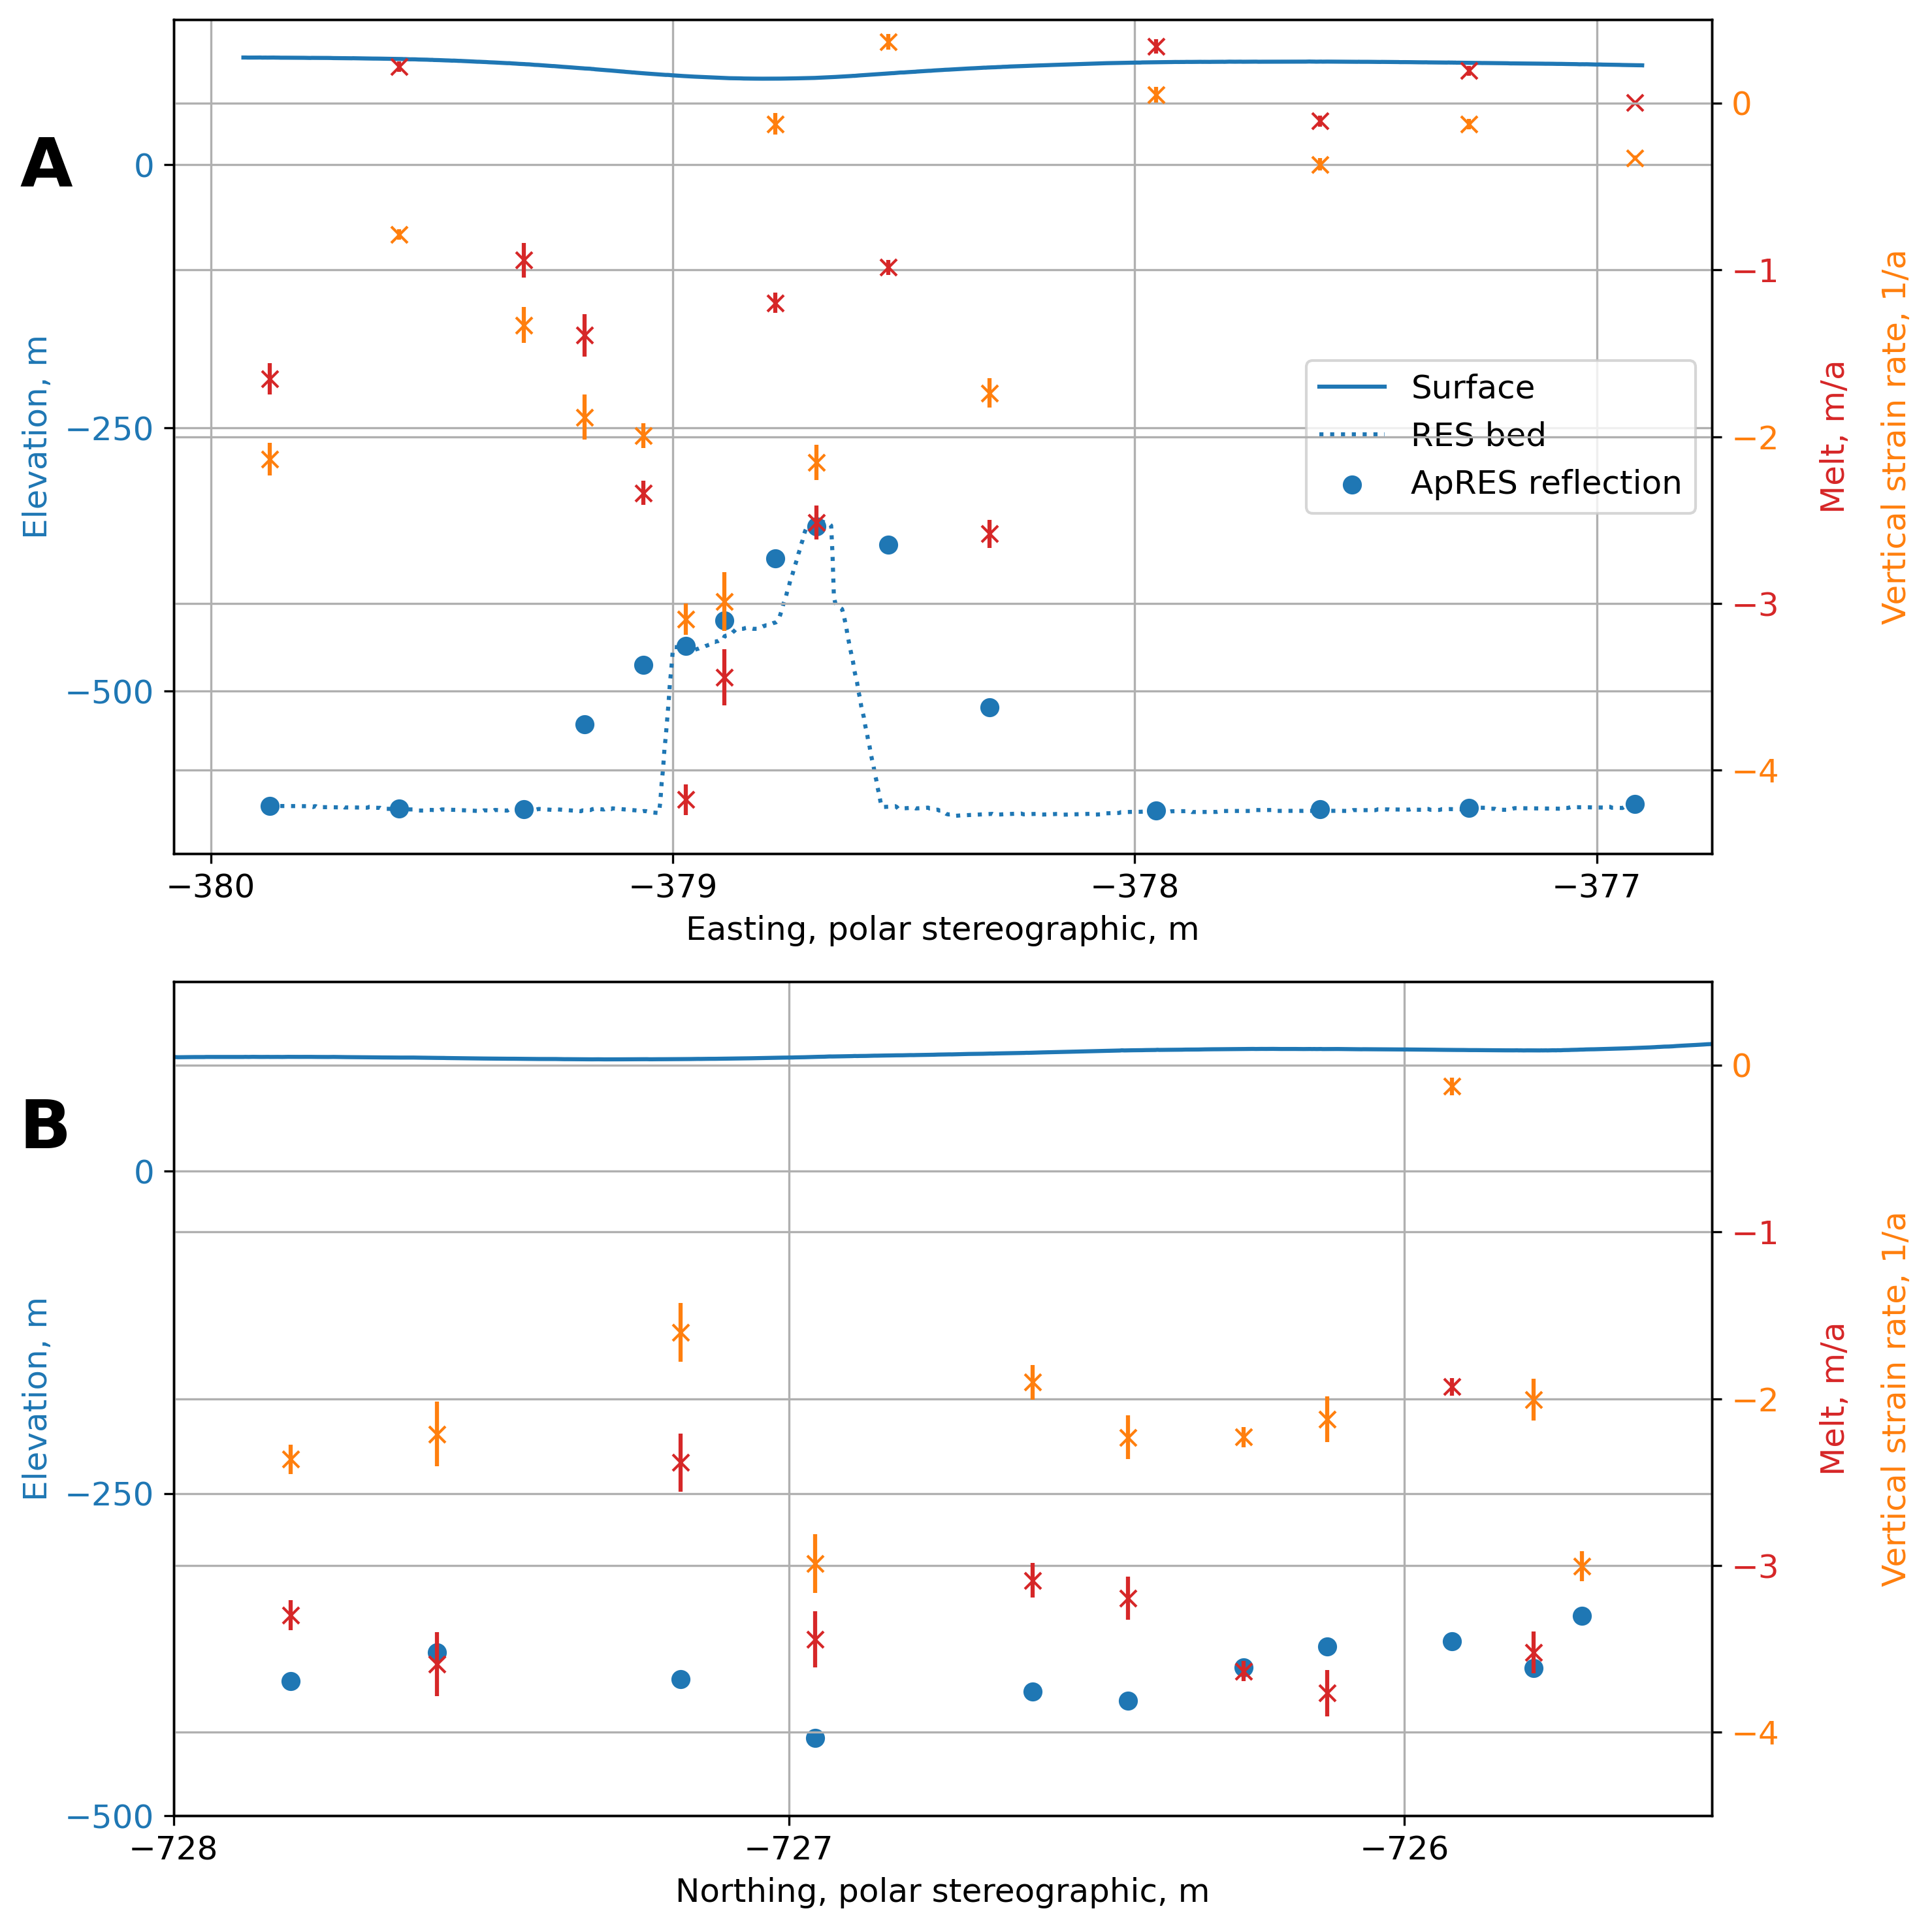

In [41]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
font = {'size'   : 12}

mpl.rc('font', **font)

fig, [ax1,axb] = plt.subplots(2,1,figsize=(10,10),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('Easting, polar stereographic, m')
ax1.set_ylabel('Elevation, m', color=color)
ax1.plot(radar_APREScross.geometry.x/1000,radar_APREScross.height+geoid_correction, color=color,label='Surface')
ax1.plot(gdfcc_res_x/1000,gdfcc_res_bed +geoid_correction+res_correction, ':', color=color,label='RES bed')
ax1.scatter(gdfcc.x/1000,surf_fordepth - gdfcc.bed +geoid_correction+apres_firn, marker='o', color=color,label='ApRES reflection')
# ax1.scatter(gdf.iloc[-1].x/1000,surf_fordepth[-1] - gdf.iloc[-1].bed +geoid_correction, marker='o', color='pink',label='Base',s=6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.set_yticks([-500,-250,0])
ax1.set_xticks(xgrid/1000)



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with ax1
ax2.errorbar(gdfcc.x/1000,gdfcc.meltRate,yerr=gdfcc.meltRateError,xerr=0,marker='x', color=color,linestyle="None")
# ax2.errorbar(gdf2.x/1000,gdf2.meltRate+1,yerr=gdf2.meltRateError,xerr=0,marker='1', color=color,linestyle="None")
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
# ax2.axhline(y=0,color='r',linestyle=':')
ax2.yaxis.set_label_coords(1.07, 0.5)
ax2.set_yticks([-3,-1])
ax2.set_ylim([-4.5,0.5])

ax3 = ax1.twinx() 

color = 'tab:orange'
ax3.set_ylabel('Vertical strain rate, 1/a', color=color)  # we already handled the x-label with ax1
ax3.yaxis.set_label_coords(1.11, 0.5)
ax3.errorbar(gdfcc.x/1000,gdfcc.dhStrain,yerr=gdfcc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid()
ax3.set_yticks([-4,-2,0])
ax3.set_ylim([-4.5,0.5])
# ax3.axhline(y=0,color='orange',linestyle=':')

ax1.text(-0.1, 0.8, 'A', transform=ax1.transAxes, 
            size=25, weight='bold')

ax1.legend()
############################################################==========================================
#Bottom plot

color = 'tab:blue'
axb.set_xlabel('Northing, polar stereographic, m')
axb.set_ylabel('Elevation, m', color=color)
axb.scatter(gdfdc.y/1000,surf_fordepth2 - gdfdc.bed +geoid_correction, marker='o', color=color)
axb.plot(radar_APRESdown.geometry.y.iloc[startat:]/1000,radar_APRESdown.height.iloc[startat:]+geoid_correction + apres_firn, color=color,label='Surface')
axb.tick_params(axis='y', labelcolor=color)
axb.grid()
axb.set_xticks([-728,-727,-726])
axb.set_xlim([-728,-725.5])
axb.set_yticks([-500,-250,0])


ax2b = axb.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2b.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with axb
ax2b.errorbar(gdfdc.y/1000,gdfdc.meltRate,yerr=gdfdc.meltRateError,xerr=0,marker='x', color=color,linestyle="None")
# ax2b.scatter(gdf.x,gdf.melt_rate,marker='s', color=color)
ax2b.tick_params(axis='y', labelcolor=color)
ax2b.grid()
# ax2b.axhline(y=0,color='r',linestyle=':')
ax2b.yaxis.set_label_coords(1.07, 0.5)
ax2b.set_yticks([-3,-1])
ax2b.set_ylim([-4.5,0.5])


ax3b = axb.twinx() 

color = 'tab:orange'
ax3b.set_ylabel('Vertical strain rate, 1/a', color=color)  # we already handled the x-label with axb
ax3b.yaxis.set_label_coords(1.11, 0.5)
ax3b.errorbar(gdfdc.y/1000,gdfdc.dhStrain,yerr=gdfdc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3b.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3b.tick_params(axis='y', labelcolor=color)
ax3b.grid()
ax3b.set_yticks([-4,-2,0])
ax3b.set_ylim([-4.5,0.5])
# ax3b.axhline(y=0,color='orange',linestyle=':')

axb.text(-0.1, 0.8, 'B', transform=axb.transAxes, 
            size=25, weight='bold')


# axb.legend(loc= 'upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/APRES_melt.png')

plt.show()

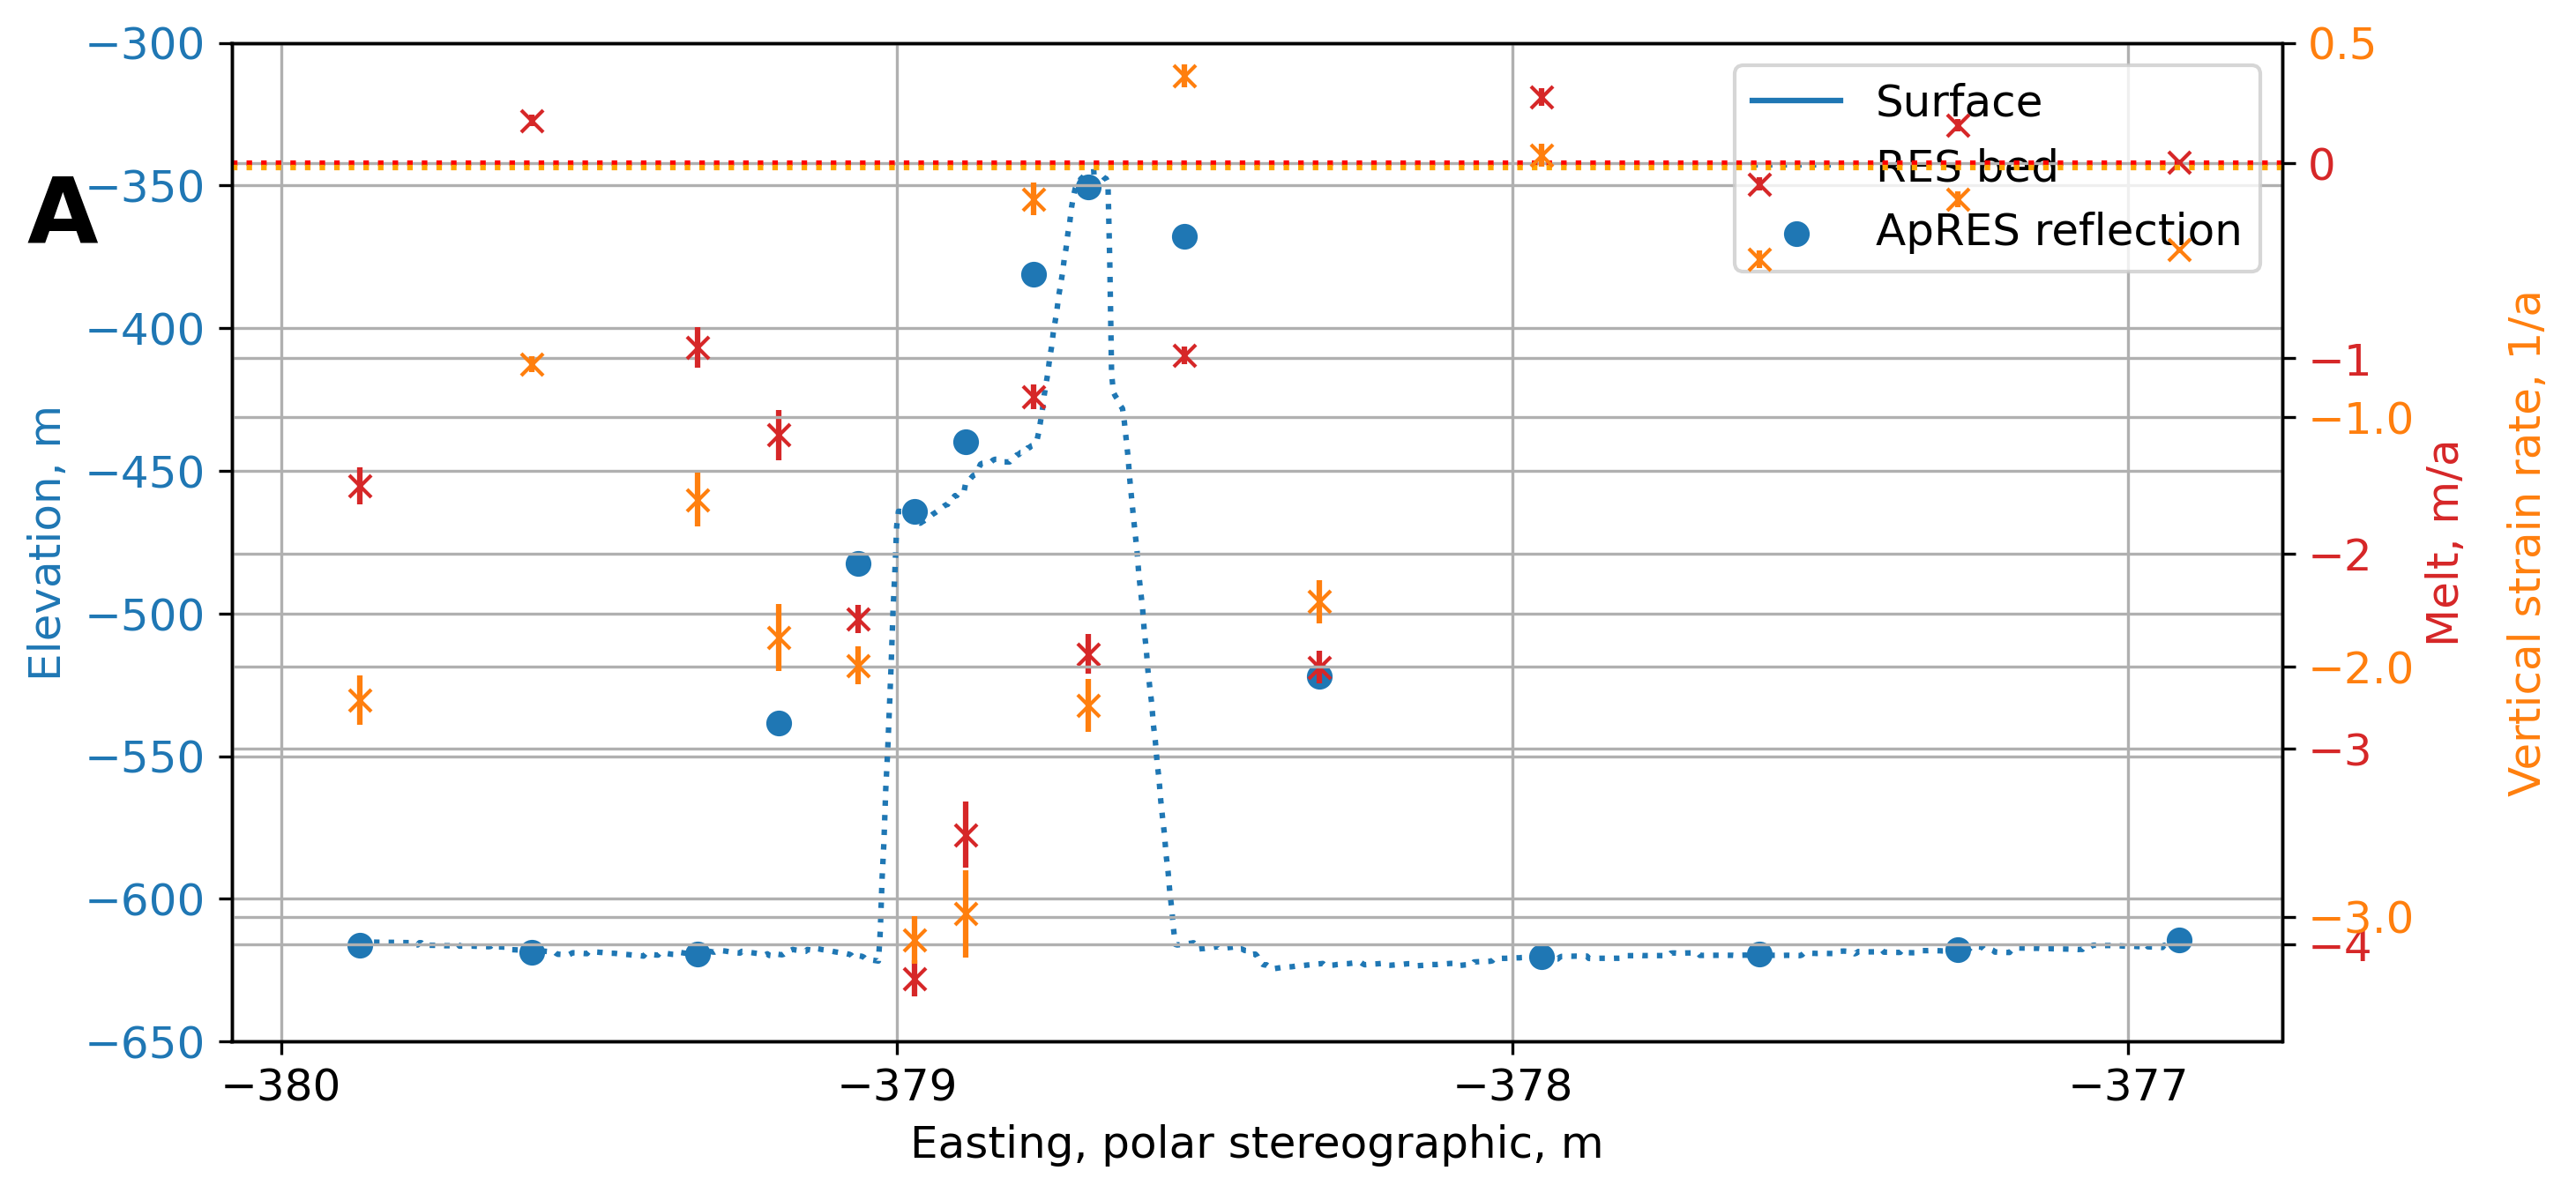

In [23]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
font = {'size'   : 12}

mpl.rc('font', **font)

fig, ax1 = plt.subplots(1,1,figsize=(10,5),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('Easting, polar stereographic, m')
ax1.set_ylabel('Elevation, m', color=color)
ax1.plot(radar_APREScross.geometry.x/1000,radar_APREScross.height+geoid_correction, color=color,label='Surface')
ax1.plot(gdfcc_res_x/1000,gdfcc_res_bed +geoid_correction-16, ':', color=color,label='RES bed')
ax1.scatter(gdfcc.x/1000,surf_fordepth - gdfcc.bed +geoid_correction, marker='o', color=color,label='ApRES reflection')
# ax1.scatter(gdf.iloc[-1].x/1000,surf_fordepth[-1] - gdf.iloc[-1].bed +geoid_correction, marker='o', color='pink',label='Base',s=6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.set_xticks(xgrid/1000)
ax1.set_ylim([-650, -300])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Melt, m/a', color=color)  # we already handled the x-label with ax1
ax2.errorbar(gdfcc.x/1000,gdfcc.meltRate,yerr=gdfcc.meltRateError,xerr=0,marker='x', color=color,linestyle="None")
# ax2.errorbar(gdf2.x/1000,gdf2.meltRate+1,yerr=gdf2.meltRateError,xerr=0,marker='1', color=color,linestyle="None")
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
ax2.axhline(y=0,color='r',linestyle=':')
ax2.yaxis.set_label_coords(1.07, 0.5)

ax3 = ax1.twinx() 

color = 'tab:orange'
ax3.set_ylabel('Vertical strain rate, 1/a', color=color)  # we already handled the x-label with ax1
ax3.yaxis.set_label_coords(1.11, 0.5)
ax3.errorbar(gdfcc.x/1000,gdfcc.dhStrain,yerr=gdfcc.dheStrain,xerr=0,marker='x', color=color,linestyle="None")
# ax3.scatter(gdf.x,gdf.vertical_strain_rate,marker='s', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid()
ax3.set_yticks([-3,-2,-1,0.5])
ax3.set_ylim([-3.5,0.5])
ax3.axhline(y=0,color='orange',linestyle=':')

ax1.text(-0.1, 0.8, 'A', transform=ax1.transAxes, 
            size=25, weight='bold')

ax1.legend()
############################################################==========================================


plt.show()